# Future Vision Transport : Design an Autonomous Vehicle

## Context

"Future Vision Transport" is a company building embedded computer vision systems for autonomous vehicles. 

The goal here is to build a model able to classify each pixel of an image into one of the given categories of objects, and expose this model's API as a web service.
This problem is known as "Semantic Segmentation" and is a challenge for the autonomous vehicle industry.

We will compare different models (varying architecture, augmentation method and image resizing) and their performances on the Cityscapes dataset. We will use AzureML and Azure App Service to deploy our models.


## State of the art

In [Computer Vision](https://en.wikipedia.org/wiki/Computer_vision "Computer Vision"), the problem of [Semanitc Segmentation](https://en.wikipedia.org/wiki/Semantic_segmentation "Semantic Segmentation") is to classify each pixel of an image into one of the given categories of objects.


### Deep Neural Network (DNN) models

The basic principle of DNNs for Semantic Segmentation is basically to :

- **Down-sampling / Encoder** : use Convolutional Neural Network (CNN) layers to extract features from the input image
- **Up-sampling / Decoder** : use fully connected layer to classify each pixel into one of the given categories of objects

![Encoder / Decoder architecture](img/encoder-decoder.png "Encoder / Decoder architecture")

Over the time, research teams have produced more sophisticated models with more layers, connections between layers and different convolution kernels in order to improve the prediction accuracy.

The major models are :

- [FCN (2015)](https://arxiv.org/abs/1411.4038 "Fully Convolutional Network") : Fully Convolutional Networks

[![FCN (2015)](img/FCN.png)](https://arxiv.org/abs/1411.4038 "Fully Convolutional Network")

- [U-Net (2015)](https://arxiv.org/abs/1505.04597 "U-Net") : a deep neural network architecture with a U-shaped structure

[![U-Net (2015)](img/UNet.png)](https://arxiv.org/abs/1505.04597 "U-Net")

- [PSPNet (2017)](https://arxiv.org/abs/1612.01105 "Pyramid Scene Parsing Network") : Pyramid Scene Parsing Network - a deep neural network architecture with a pyramid structure

[![PSPNet (2017)](img/PSPNet.png)](https://arxiv.org/abs/1612.01105 "Pyramid Scene Parsing Network")

- [DenseNet (2018)](https://arxiv.org/abs/1608.06993 "Densely Connected Convolutional Networks") : Densely Connected Convolutional Networks - a deep neural network architecture with a densely connected structure

[![DenseNet (2018)](img/DenseNet.png)](https://arxiv.org/abs/1608.06993 "Densely Connected Convolutional Networks")

- [DeepLabv3+ (2018)](https://arxiv.org/abs/1802.02611 "DeepLab") : an Encoder-Decoder architecture with Atrous Convolution

[![DeepLabv3+ (2018)](img/DeepLab.png)](https://arxiv.org/abs/1802.02611 "DeepLab")


### Results on the Cityscapes Dataset

The [Cityscapes Dataset](https://www.cityscapes-dataset.com/ "Cityscapes Dataset") is a large dataset of images captured by a car dash camera in the city, with their corresponding labels.

[![Semantic Segmentation on Cityscapes State of the Art](img/chart.jpeg "Semantic Segmentation on Cityscapes State of the Art")](https://paperswithcode.com/sota/semantic-segmentation-on-cityscapes "Semantic Segmentation on Cityscapes State of the Art")


## Project modules

- [`notebooks/`](https://github.com/fleuryc/OC_AI-Engineer_P8_Design-an-autonomous-vehicle/blob/main/notebooks "Notebooks") :
  - [train.ipynb](https://github.com/fleuryc/OC_AI-Engineer_P8_Design-an-autonomous-vehicle/blob/main/notebooks/train.ipynb "train.ipynb") : orchestration of the models training process in AzureML
  - [eval.ipynb](https://github.com/fleuryc/OC_AI-Engineer_P8_Design-an-autonomous-vehicle/blob/main/notebooks/eval.ipynb "eval.ipynb") : running the evaluation of the models in AzureML
  - [deploy.ipynb](https://github.com/fleuryc/OC_AI-Engineer_P8_Design-an-autonomous-vehicle/blob/main/notebooks/deploy.ipynb "deploy.ipynb") : orchestration of the models endpoint deployment process in AzureML
  - [predict.ipynb](https://github.com/fleuryc/OC_AI-Engineer_P8_Design-an-autonomous-vehicle/blob/main/notebooks/predict.ipynb "predict.ipynb") : orchestration of the models prediction tests process in AzureML
  - [`azureml/`](https://github.com/fleuryc/OC_AI-Engineer_P8_Design-an-autonomous-vehicle/tree/main/notebooks/azureml "AzureML code") : contains the code deployed in AzureML training and prediction environments.
- [`webapp/`](https://github.com/fleuryc/OC_AI-Engineer_P8_Design-an-autonomous-vehicle/tree/main/webapp "WebApp code") : contains the webapp deployed in Azure App Service.
- [`src/`](https://github.com/fleuryc/OC_AI-Engineer_P8_Design-an-autonomous-vehicle/tree/main/src "Source code") : contains the helpers functions and project specific code.


We will use the [Python](https://www.python.org/about/gettingstarted/) programming language, and present here the code and results in this [Notebook JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html) file.

We will use the usual libraries for data exploration, modeling and visualisation :

- [NumPy](https://numpy.org/doc/stable/user/quickstart.html) and [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) : for maths (stats, algebra, ...) and large data manipulation
- [Plotly](https://plotly.com/python/getting-started/) : for interactive data visualization

We will also use libraries specific to the goals of this project :

- [TensorFlow](https://www.tensorflow.org/versions/r1.12/get_started/index.html) and [Keras](https://keras.io/getting-started/sequential-model-guide/) : for deep learning
- Image processing :
  - [Pillow](https://pillow.readthedocs.io/en/stable/index.html) : for image manipulation
  - [OpenCV](https://docs.opencv.org/3.4.1/d4/da8/tutorial_py_image_arithmetics.html) : for image processing
  - [Albumentations](https://albumentations.ai/docs/#introduction-to-image-augmentation) : for image augmentation


In [ ]:
import base64
import json
import os
import random
import time
from io import BytesIO
from pathlib import Path

import albumentations as aug
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import requests
import tensorflow as tf
from dotenv import dotenv_values, load_dotenv
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

import azureml.cityscapes as cityscapes
from azureml.core import Model, Workspace
from azureml.models import deeplab_v3plus, unet_xception
from azureml.models.keras_segmentation.models import fcn

pio.renderers.default = "notebook"

load_dotenv()
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")
AZURE_RESOURCE_GROUP = os.getenv("AZURE_RESOURCE_GROUP")
AZURE_WORKSPACE_NAME = os.getenv("AZURE_WORKSPACE_NAME")


## Exploratory data analysis (EDA)

We are going to load the data and analyse the distribution of each variable.


### Load data

Let's download the data from the [Cityscapes](https://www.cityscapes-dataset.com/) dataset and look at what it contains.

The dataset is composed of the following image files :
- `gtFine/` : contains the ground truth images
  - `test/`, `train/` and `val/` : contains the images for the three different splits of the dataset
    - `berlin/`, `frankfurt/`, `munich/`, ... : contains the images for different cities of the dataset
      - `*_gtFine_color.png` : contains the labels colors
      - `*_gtFine_instanceIds.png` : contains the instance ids
      - `*_gtFine_labalIds.png` : contains the label ids
      - `*_gtFine_polygons.json` : contains the polygon shapes
- `leftImg8bit` : the raw images of the dataset

We are not going to use the polygon shapes, but we will use the instance ids to build the ground truth images.

There are :
- 2975 train images
- 500 validation images
- 1525 test images

According to the [Cityscapes dataset documentation](https://www.cityscapes-dataset.com/documentation/cityscapes-dataset-documentation), the images are of size 2048x1024 and are in RGB format.

We will not use the object labels (32 labels), but the 8 label categories : "void", "flat", "construction", "object", "nature", "sky", "human" and "vehicle".


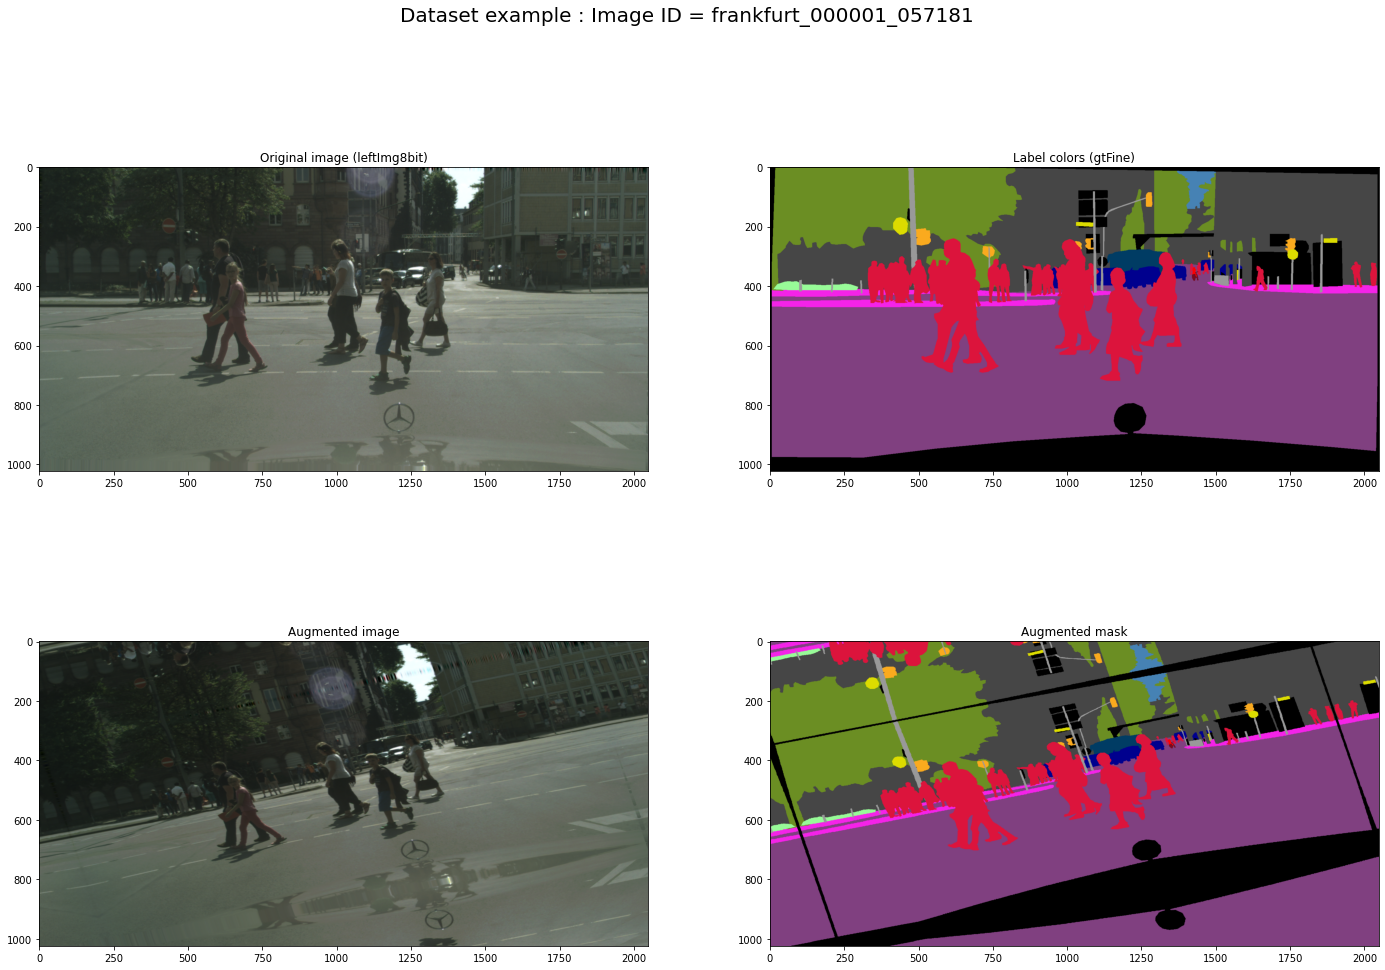

In [15]:
# Let's load the images 

raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_gtFine_labelIds.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)


rand_idx = np.random.randint(0, len(val_input_img_paths))
image_id = (
    str(val_input_img_paths[rand_idx])
    .split("/")[-1]
    .replace("_leftImg8bit.png", "")
)
img_size = np.array(Image.open(val_input_img_paths[rand_idx])).shape



augment = aug.Compose(
    [
        aug.OneOf(  # Color augmentations
            [
                aug.RandomBrightnessContrast(),
                aug.RandomGamma(),
                aug.RandomToneCurve(),
            ]
        ),
        aug.OneOf(  # Camera augmentations
            [
                aug.MotionBlur(),
                aug.GaussNoise(),
            ]
        ),
        aug.OneOf(  # Geometric augmentations
            [
                aug.HorizontalFlip(),
                aug.RandomCrop(
                    width=int(img_size[0] / random.uniform(1.0, 2.0)),
                    height=int(img_size[1] / random.uniform(1.0, 2.0)),
                ),
                aug.SafeRotate(
                    limit=15,
                ),
            ]
        ),
    ]
)

img = np.array(Image.open(val_input_img_paths[rand_idx]))
mask = np.array(Image.open(val_label_colors_img_paths[rand_idx]))

augmented = augment(
    image=img,
    mask=mask,
)



# plot images
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(24, 16),
)
fig.suptitle(f"Dataset example : Image ID = {image_id}", fontsize=20)

ax[0,0].title.set_text("Original image (leftImg8bit)")
ax[0,0].imshow(img)

ax[0,1].title.set_text("Label colors (gtFine)")
ax[0,1].imshow(np.array(mask))

ax[1,0].title.set_text("Augmented image")
ax[1,0].imshow(np.array(augmented["image"]))

ax[1,1].title.set_text("Augmented mask")
ax[1,1].imshow(np.array(augmented["mask"]))

plt.show()



Now that we have an idea of what the dataset contains, let's understand it further by computing statistics.

In [22]:
# Let's observe the categories distribution
subset_size = 1000

data = [
    np.unique(
        cityscapes.cityscapes_label_ids_to_category_ids(
            np.array(Image.open(img))
        ).flatten(),
        return_counts=True,
    )[1]
    / (img_size[0] * img_size[1])
    for img in tqdm(random.choices(train_label_ids_img_paths, k=subset_size))
]

df = pd.DataFrame(data)


fig = go.Figure()
for category in tqdm(cityscapes.CITYSCAPES_CATEGORIES):
    fig.add_trace(
        go.Box(
            y=df[category.id],
            name=category.name,
            marker_color=f"rgb{category.color_rgb}",
        )
    )

fig.update_traces(boxmean="sd")
fig.update_traces(notched=True)
fig.update_layout(title_text=f"Pixel category distribution (n={subset_size})")
fig.show()


100%|██████████| 8/8 [00:00<00:00, 1286.79it/s]


We can see that the most important category for an autonomous vehicle ("human") is the least represented in the dataset.

This means the problem is imbalanced and we have to take into account that the most important class is under represented.

## Models selection and training


We are going to evaluate the performance of different models, with different parameters :
- DNN architectures : `FCN-8`, `U-Net` and `Deeplab v3+`
- image input sizes : from `64x64` to `640x640` pixels
- image augmentation : color (brightness, gamma, tone), camera (blur, noise), geometric (flip, crop, rotate)

The trianing experiment will be run in AzureML, and the results will be stored in the AzureML environment.


### Selected models architectures

We can observe the architecture of the three selected models :

| Model name | FCN-8 | U-Net | Deeplab v3+ |
|------------|-------|-------|-------------|
| **Total params** | 69,775,768 | 2,060,424 |  2,143,304 |
| **Trainable params** | 69,773,848 | 2,056,648 | 2,110,216 |
| **Non-trainable params** | 1,920 | 3,776 |  33,088 |
| **Architecture** | ![FCN-8](img/fcn_8_model.png "FCN-8") | ![U-Net](img/unet_xception_model.png "U-Net") | ![DeepLabv3+](img/deeplab_v3plus_model.png "DeepLab") |

### Loss and metric

There multiple ways to evaluate the model performance.

| Loss | Metric | Intersection vs. Union | Confusion Matrix | Pros | Cons|
|------|--------|----------------|------|-----|------|
| Sparse Categorical Cross-entropy | Pixel Accuracy | $ - $ | $ \frac{TP + TN}{TP + FP + TN + FN} $ | Easy to interpret | Bad with imbalanced target classes. |
| Dice | F1 | $ \frac{2 \lvert\lvert A \cap B \rvert\rvert}{\lvert\lvert A \rvert\rvert + \lvert\lvert B \rvert\rvert} $ | $ \frac{2 TP}{2 TP + FP + FN} $ | Good with imbalanced target classes. | Not easy to interpret. |
| Jaccard | Intersection over Union (IoU) | $ \frac{\lvert\lvert A \cap B \rvert\rvert}{\lvert\lvert A \cup B \rvert\rvert} $ | $ \frac{TP}{TP + FP + FN} $ | Easy to interpret. Good with imbalanced target classes. |  |

We are going to use the **Jaccard Index** as the model's loss and the **Mean IoU** as the model's metric.


### Training process

The code is available in the [train.ipynb](train.ipynb "train.ipynb") file :
- log into the AzureML workspace
- create (or load existing) train environment :
  - based on the [Dockerfile](azureml/Dockerfile "train Dockerfile") image
  - deployed on a GPU capable custom environment
- execute [train.py](azureml/train.py "train script") :
  - load the images with the [Data Generator](azureml/cityscapes.py:122 "Data Generator")
  - use [Jaccard index](azureml/cityscapes.py:201 "Jaccard index") for the loss function
  - use [Albumentations](azureml/train.py:81 "Albumentations")
  - use [Early Stopping](azureml/train.py:237 "EarlyStopping") and [Reduce Learning Rate On Plateau](azureml/train.py:230 "ReduceLROnPlateau") to control the training duration
  - use [Mean IoU](azureml/train.py:242 "Mean IoU") as the evaluation metric


### Training results

The training results are available in the [AzureML experiment](https://ml.azure.com/experiments/id/a2f53c2b-086c-46d4-876f-e302c35ca761?wsid=/subscriptions/da2e4791-6dd1-422b-848a-a961cef6ab89/resourceGroups/OC_P8/providers/Microsoft.MachineLearningServices/workspaces/oc-p8-ml-workspace&tid=43204f6d-c600-4585-985a-6bafda08d2bb "AzureML experiment").


In [3]:
results_df = pd.read_csv("../results/models_comparison.csv")

results_df

Architecture  Augmentation  Image resize  \
0           fcn_8          True           512   
1           fcn_8         False           512   
2   deeplab_v3plu          True           512   
3   deeplab_v3plu         False           512   
4   unet_xception          True           512   
5   unet_xception         False           512   
6           fcn_8          True           256   
7           fcn_8         False           256   
8   deeplab_v3plu          True           256   
9   deeplab_v3plu         False           256   
10  unet_xception          True           256   
11  unet_xception         False           256   
12          fcn_8          True           128   
13          fcn_8         False           128   
14  deeplab_v3plu          True           128   
15  deeplab_v3plu         False           128   
16  unet_xception          True           128   
17  unet_xception         False           128   
18          fcn_8          True            64   
19          fcn_8         False            64   
20  deeplab_v3plu          True            64   
21  deeplab_v3plu         False            64   
22  unet_xception          True            64   
23  unet_xception         False            64   

    Validation Loss (Jaccard index)  Validation Metric (Mean IoU)  \
0                             0.340                         0.398   
1                             0.247                         0.545   
2                             0.201                         0.645   
3                             0.245                         0.600   
4                             0.281                         0.515   
5                             0.239                         0.553   
6                             0.603                         0.304   
7                             0.271                         0.559   
8                             0.261                         0.559   
9                             0.241                         0.630   
10                            0.430                         0.446   
11                            0.270                         0.561   
12                            0.385                         0.471   
13                            0.323                         0.520   
14                            0.408                         0.454   
15                            0.329                         0.519   
16                            0.382                         0.481   
17                            0.328                         0.516   
18                            0.765                         0.198   
19                            0.406                         0.464   
20                            0.576                         0.340   
21                            0.754                         0.242   
22                            0.996                         0.113   
23                            0.954                         0.123   

    Training duration per epoch  
0                        341.76  
1                        329.58  
2                        331.00  
3                        356.00  
4                        349.00  
5                        337.11  
6                        337.22  
7                        325.20  
8                        295.52  
9                        297.65  
10                       313.85  
11                       325.00  
12                       293.14  
13                       323.60  
14                       352.57  
15                       270.68  
16                       295.13  
17                       300.64  
18                       307.92  
19                       286.76  
20                       350.33  
21                       387.40  
22                       460.17  
23                       420.17

In [4]:
fig = px.scatter(
    results_df,
    x="Training duration per epoch",
    y="Validation Metric (Mean IoU)",
    color="Architecture",
    size="Image resize",
    symbol="Augmentation",
    title="Models performances",
)
fig.show()


In [5]:
fig = px.box(
    results_df,
    x="Architecture",
    y="Training duration per epoch",
    color="Architecture",
    title="Architecture effect on Duration : -4.5% (DeepLab vs. U-Net) / +4.6% (DeepLab vs. FCN-8) on average",
)
fig.update_traces(boxmean="sd")
fig.show()

`FCN-8` is slightly faster to train than `DeepLabV3+` and `U-Net`.


In [6]:
fig = px.box(
    results_df,
    x="Architecture",
    y="Validation Metric (Mean IoU)",
    color="Architecture",
    title="Architecture effect on Metric : +45% (DeepLab vs. U-Net) / +24% (DeepLab vs. FCN-8) on average",
)
fig.update_traces(boxmean="sd")
fig.show()

`DeepLabV3+` performs much better than `FCN-8` and `U-Net`.


In [7]:
fig = px.box(
    results_df,
    x="Augmentation",
    y="Training duration per epoch",
    color="Architecture",
    title="Augmentation effect on Duration : +2.2% (with vs. without) on average",
)
fig.update_traces(boxmean="sd")
fig.show()

Adding image augmentation reduces increases slightly the training time.


In [49]:
fig = px.box(
    results_df,
    x="Augmentation",
    y="Validation Metric (Mean IoU)",
    color="Architecture",
    title="Augmentation effect on Metric : -13% (with vs. without) on average",
)
fig.update_traces(boxmean="sd")
fig.show()

Adding the image augmentation **reduces** the models performance : ~ **-20%** Mean IoU on average with augmentation vs. without.

This observation is explained by the fact that by adding augmentation, the models are trained on a dataset that is not representative of the validation dataset, thus the models trained on augmented images underfit the validation dataset


In [51]:
fig = px.box(
    results_df,
    x="Image resize",
    y="Training duration per epoch",
    color="Architecture",
    title="Resize effect on Duration : +6% (resize=X vs. resize=X/2) on average",
)
fig.update_xaxes(type='category')
fig.update_traces(boxmean="sd")
fig.show()

Changing the image resize doesn't seem to have a significant effect on training time.

In [50]:
fig = px.box(
    results_df,
    x="Image resize",
    y="Validation Metric (Mean IoU)",
    color="Architecture",
    title="Resize effect on Metric : +56% (resize=X vs. resize=X/2) on average",
)
fig.update_xaxes(type='category')
fig.update_traces(boxmean="sd")
fig.show()

Increasing the input image resize improves greatly the models performance, especially for `DeepLabV3+`.

Overall, we can conclude that the best results are obtained with `DeepLabV3+`, without image augmentation.

## Model deployment and testing

In order to provide the predictions service as requested, we will deploy our model in production. We will use two approaches : 
- deploy our model as a AzureML Endpoint
- deploy our model as part of a Flask webapp deployed on Azure App Service


### Deployment as AzureML Endpoint


The code is available in the [deploy.ipynb](deploy.ipynb "deploy.ipynb") file :
- log into the AzureML workspace
- create (or load existing) prediction environment :
  - based on the AzureML's latest inferencing stack
  - with custom Conda dependancies [conda_dependencies.yml](azureml/conda_dependencies.yml "Conda dependancies")
  - create a dedicated Azure Compute Instance
- once the model is deployed and the Compute Instance is running, we store the API credentials in `.env` files

#### Test the Endpoints

We can test the Endpoint by calling the API with a sample image.
The results are visible in the [predict.ipynb](predict.ipynb "predict.ipynb") file :

| Model prediction and time |
|-------------|
|![U-Net 64px : 5.76s](img/pred_unet_xception_64.png "U-Net : 5.76s")|
|![U-Net 64px with augmentation : 5.65s](img/pred_unet_xception_64_augment.png "U-Net 64px with augmentation : 5.65s")|
|![DeepLab 64px : 5.94s](img/pred_deeplab_v3plus_64.png "DeepLab 64px : 5.94s")|
|![DeepLab 64px with augmentation : 5.97s](img/pred_deeplab_v3plus_64_augment.png "DeepLab 64px with augmentation : 5.97s")|
|![U-Net 128px : 9.83s](img/pred_unet_xception_128.png "U-Net 128px : 9.83s")|
|![U-Net 128px with augmentation : 9.55s](img/pred_unet_xception_128_augment.png "U-Net 128px with augmentation : 9.55s")|
|![DeepLab 128px : 14.38s](img/pred_deeplab_v3plus_128.png "DeepLab 128px : 14.38s")|
|![DeepLab 128px with augmentation : 11.08s](img/pred_deeplab_v3plus_128_augment.png "DeepLab 128px with augmentation : 11.08s")|
|![U-Net 256px : 41.91s](img/pred_unet_xception_256.png "U-Net 256px : 41.91s")|
|![U-Net 256px with augmentation : 32.52s](img/pred_unet_xception_256_augment.png "U-Net 256px with augmentation : 32.52s")|
|![DeepLab 256px : 27.02s](img/pred_deeplab_v3plus_256.png "DeepLab 256px : 27.02s")|
|![DeepLab 256px with augmentation : 23.85s](img/pred_deeplab_v3plus_256_augment.png "DeepLab 256px with augmentation : 23.85s")|


We can see that the prediction improves with the input size, but the prediction time also increases : from ~6s with 64x64 pixels to more than 40s with 256x256 pixels, until the API fails with a timeout error (60s limit) for inputs > 320 pixels.

We can also see that the `DeepLabV3+` model at 256 pixels is the only model to correctly predict the "human" pixels.


### Deployment as Flask webapp


We developed a simple web application based on the Flask framework.
The code is available in the [../webapp](webapp "webapp") directory :
- [app.py](webapp/app.py "app.py") defines two routes :
  - `/` : the index page supposed to be accessed by actual human users through their browser
    - displays a form to input a image ID for prediction
    - on submit, displays the input image's segmentation mask predicted by our best model (best performance with acceptable prediction time) : `Deeplab v3+` without augmentation and image resized to 256x256 pixels
  - `/api` : the API endpoint supposed to be queried by other services
    - accepts an image ID as input
    - returns the input image's segmentation mask predicted by our best model (best performance with acceptable prediction time) : `Deeplab v3+` without augmentation and image resized to 256x256 pixels
- the web app is deployed on Azure App Service : https://ocp8-webapp.azurewebsites.net/


### Prediction time comparison


Let's compare the time required to predict the segmentation mask for the input image on the two deployment approaches, as well as a local prediction.

We can see that the local prediction is a dramatically faster approach. This is mosltly due to the image transfer time required to query the distant Endpoint and API. 
This paradigm is what is called **Edge Computing** : running prediction locally on IoT devices is much faster than sending the data and running it on a server.

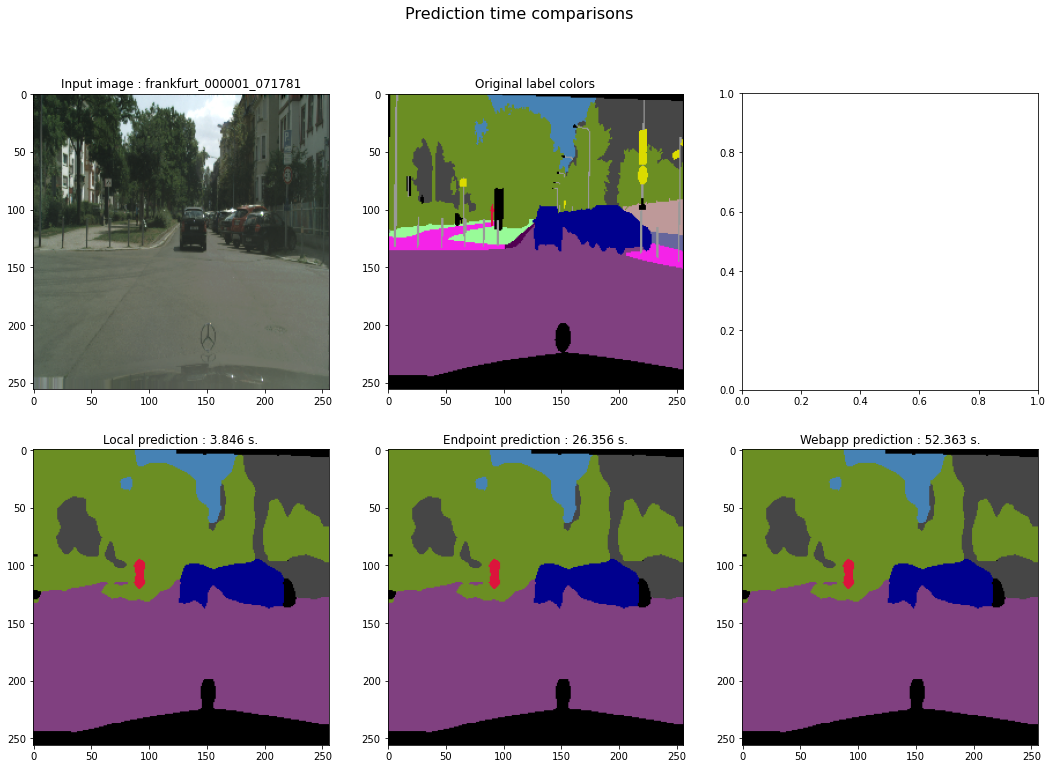

In [ ]:
# Get the model
model_name = "deeplab_v3plus_256"
model_input_size = int(model_name.replace("_augment", "").split("_")[-1])
img_size = (model_input_size, model_input_size)


with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")

    im_binary = base64.b64decode(im_b64)
    im_bytes = BytesIO(im_binary)
    input_img = Image.open(im_bytes).resize(img_size)

    # Local model prediction
    model_path = Path("./../results/downlad/", model_name)
    if not Path(model_path, "model").exists():
        Model(
            Workspace(
                subscription_id=AZURE_SUBSCRIPTION_ID,
                resource_group=AZURE_RESOURCE_GROUP,
                workspace_name=AZURE_WORKSPACE_NAME,
            ),
            model_name,
        ).download(target_dir=model_path)

    model = tf.keras.models.load_model(
        Path(model_path, "model/data/model"),
        custom_objects={
            "UpdatedMeanIoU": cityscapes.UpdatedMeanIoU,
            "jaccard_loss": cityscapes.jaccard_loss,
        },
    )

    start = time.time()
    output_img = model.predict(np.expand_dims(input_img, 0))

    local_predict_time = time.time() - start
    local_output_mask = cityscapes.cityscapes_category_ids_to_category_colors(
        np.squeeze(
            np.argmax(model.predict(np.expand_dims(input_img, 0)), axis=-1)
        )
    )

    # AzureML registered model Endpoint prediction
    inference_config = dotenv_values(Path(f"../.env.{model_name}"))
    url = inference_config["AZURE_INFERENCE_ENDPOINT"]
    headers = {
        "Content-Type": "application/json",
        "Authorization": ("Bearer " + inference_config["AZURE_INFERENCE_KEY"]),
    }
    data = {"image": im_b64_str}
    payload = str.encode(json.dumps(data))
    r = requests.post(url, headers=headers, data=payload)
    result = r.content

    endpoint_predict_time = r.elapsed.total_seconds()
    endpoint_output_mask = Image.open(BytesIO(base64.b64decode(result)))

    # Flask WebApp prediction
    url = "https://ocp8-webapp.azurewebsites.net/api"
    headers = {
        "Content-Type": "application/json",
    }
    data = {"image_id": image_id}
    r = requests.get(url, headers=headers, params=data)
    predict_time = r.elapsed.total_seconds()
    result = json.loads(r.content)

    webapp_predict_time = r.elapsed.total_seconds()
    webapp_output_mask = Image.open(
        BytesIO(base64.b64decode(result["categories_img_b64_str"]))
    )

    # plot images
    fig, ax = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(18, 12),
    )
    fig.suptitle("Prediction time comparisons", fontsize=16)

    ax[0, 0].title.set_text("Input image : {}".format(image_id))
    val_img = tf.keras.utils.load_img(
        val_input_img_paths[rand_idx], target_size=img_size
    )
    ax[0, 0].imshow(val_img)

    ax[0, 1].title.set_text("Original label colors")
    val_colors = tf.keras.utils.load_img(
        val_label_colors_img_paths[rand_idx], target_size=img_size
    )
    ax[0, 1].imshow(val_colors)

    ax[0, 2].title.set_text("Original category colors")
    val_colors = tf.keras.utils.load_img(
        val_label_colors_img_paths[rand_idx], target_size=img_size
    )
    ax[0, 2].imshow(val_colors)

    ax[1, 0].title.set_text(
        "Local prediction : {} s.".format(round(local_predict_time, 3))
    )
    ax[1, 0].imshow(local_output_mask)

    ax[1, 1].title.set_text(
        "Endpoint prediction : {} s.".format(round(endpoint_predict_time, 3))
    )
    ax[1, 1].imshow(endpoint_output_mask)

    ax[1, 2].title.set_text(
        "Webapp prediction : {} s.".format(round(webapp_predict_time, 3))
    )
    ax[1, 2].imshow(webapp_output_mask)

    plt.show()


## Conclusion

We have been able to evaluate the performance of different models, with different parameters, and to deploy them in production.

Two main challenges remain :
- Although the results are quite correct given the limited resources available, the best model we have trained would not be safe enough to be trusted in an actual autonomous vehicle.
- Even if the local prediction is faster that calling distant services, the prediction time is still too long for a real autonomous vehicle.

In order to miigate thos two problems, we could :
- train a faster model based on MobileNetV2 (for instance) in order to improve the performance
- train our model on many more images in order to improve the metric
